In [29]:
!pip uninstall protobuf -y
!pip install protobuf==3.20.3

In [30]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from diffusers import StableDiffusionPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)

In [31]:
from diffusers import DDPMScheduler

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

# Disable unused components (saves VRAM)
pipe.safety_checker = None
pipe.feature_extractor = None
pipe.requires_safety_checker = False

# Move only required parts to GPU
pipe.unet.to(device)
pipe.vae.to(device)

# Text encoder stays FP32 for Mix-LoRA stability
pipe.text_encoder = pipe.text_encoder.float().to(device)

# Training scheduler (not PNDM)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# Freeze base models
pipe.unet.requires_grad_(False)
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e

In [32]:
class LoRAExpert(nn.Module):
    def __init__(self, dim, rank=8):
        super().__init__()
        self.A = nn.Linear(dim, rank, bias=False)
        self.B = nn.Linear(rank, dim, bias=False)

    def forward(self, x):
        return self.B(self.A(x))

In [33]:
class MixLoRARouter(nn.Module):
    def __init__(self, dim, num_experts, top_k=2, temperature=2.0):
        super().__init__()
        self.top_k = top_k
        self.temperature = temperature
        self.router = nn.Linear(dim, num_experts)

    def forward(self, x):
        # stabilize logits
        logits = self.router(x).clamp(-10, 10)

        # temperature-scaled softmax
        probs = torch.softmax(logits / self.temperature, dim=-1)

        topk_vals, topk_idx = torch.topk(probs, self.top_k, dim=-1)
        return probs, topk_vals, topk_idx

In [34]:
class MixLoRAFFN(nn.Module):
    def __init__(self, base_mlp, model_dim, hidden_dim, num_experts=3, rank=8):
        super().__init__()

        # Base CLIP MLP (frozen)
        self.fc1 = base_mlp.fc1          
        self.fc2 = base_mlp.fc2          

        for p in self.fc1.parameters():
            p.requires_grad = False
        for p in self.fc2.parameters():
            p.requires_grad = False

        # Router on hidden space 
        self.router = MixLoRARouter(
            dim=hidden_dim,
            num_experts=num_experts
        )

        # LoRA experts (3072-dim)
        self.experts = nn.ModuleList([
            LoRAExpert(hidden_dim, rank)
            for _ in range(num_experts)
        ])

        self.last_router_probs = None

    def forward(self, x):

        # CLIP MLP first projection
        h = self.fc1(x)   

        # CLIP activation: QuickGELU
        h = h * torch.sigmoid(1.702 * h)

        # Routing
        probs, weights, indices = self.router(h)
        expert_out = torch.zeros_like(h)

        for k in range(weights.shape[-1]):
            idx = indices[..., k]
            w = weights[..., k].unsqueeze(-1)

            for e, expert in enumerate(self.experts):
                mask = (idx == e)
                if mask.any():
                    expert_out[mask] += w[mask] * expert(h[mask])

        self.last_router_probs = probs.detach()

        # Residual adapter contribution
        h = h + 0.1 * expert_out

        # CLIP MLP output projection
        return self.fc2(h)

In [35]:
def inject_mixlora(text_encoder, num_experts=3, rank=8):
    device = next(text_encoder.parameters()).device
    dtype  = next(text_encoder.parameters()).dtype

    model_dim = text_encoder.config.hidden_size  
    hidden_dim = text_encoder.text_model.encoder.layers[0].mlp.fc1.out_features  

    for layer in text_encoder.text_model.encoder.layers:
        mixlora_mlp = MixLoRAFFN(
            base_mlp=layer.mlp,
            model_dim=model_dim,
            hidden_dim=hidden_dim,
            num_experts=num_experts,
            rank=rank
        ).to(device=device, dtype=dtype)

        layer.mlp = mixlora_mlp

    return text_encoder

In [36]:
from diffusers import DDPMScheduler

# 1. Load pipeline on CPU
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

# 2. Disable unused components 
pipe.safety_checker = None
pipe.feature_extractor = None
pipe.requires_safety_checker = False

# 3. Move only required parts to GPU
pipe.unet.to(device)
pipe.vae.to(device)

# Text encoder MUST be FP32 for Mix-LoRA
pipe.text_encoder = pipe.text_encoder.float().to(device)

# Training-safe scheduler
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

# 4. Freeze base models
pipe.unet.requires_grad_(False)
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)

# 5. Inject Mix-LoRA 
pipe.text_encoder = inject_mixlora(
    pipe.text_encoder,
    num_experts=3,
    rank=8
)

# 6. Enable training ONLY for adapters + router
for layer in pipe.text_encoder.text_model.encoder.layers:
    for expert in layer.mlp.experts:
        for p in expert.parameters():
            p.requires_grad = True

    for p in layer.mlp.router.parameters():
        p.requires_grad = True

pipe.text_encoder.train()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MixLoRAFFN(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (router): MixLoRARouter(
              (router): Linear(in_features=3072, out_features=3, bias=Tr

In [37]:
class ArtStyleDataset(Dataset):
    def __init__(self, image_paths, style_name, tokenizer, size=512):
        self.image_paths = image_paths
        self.style = style_name
        self.tokenizer = tokenizer
        self.size = size

        self.style_prompts = {
            "van_gogh": "a vibrant landscape painting in the style of van gogh, bold brush strokes, expressive colors",
            "ghibli": "a detailed anime background in studio ghibli style, soft lighting, whimsical atmosphere",
            "monet": "an impressionist landscape painting in the style of claude monet, soft colors, light and water"
        }

        self.image_transform = T.Compose([
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image = self.image_transform(image)

        prompt = self.style_prompts[self.style]
        text = self.tokenizer(
            prompt,
            padding="max_length",
            truncation=True,
            max_length=77,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": text.input_ids[0],
            "attention_mask": text.attention_mask[0]
        }

In [38]:
import os

DATA_DIR_MONET = "/kaggle/input/monet2photo/trainA"

all_images = sorted([
    os.path.join(DATA_DIR_MONET, f)
    for f in os.listdir(DATA_DIR_MONET)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])

selected_images = all_images[:100]
print(f"Using {len(selected_images)} Monet images")

DATA_DIR_VANGOGH = "/kaggle/input/van-gogh-paintings/VincentVanGogh/Watercolors"

all_images2 = sorted([
    os.path.join(DATA_DIR_VANGOGH, f)
    for f in os.listdir(DATA_DIR_VANGOGH)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
])

selected_images2 = all_images2[:100]

print(f"Using {len(selected_images2)} images")

DATA_DIR_GHIBLI = "/kaggle/input/ghibli-dataset/Ghibli/testing"

g_images = []

# Walk through all subfolders
for root, dirs, files in os.walk(DATA_DIR_GHIBLI):
    if "g.png" in files:
        g_path = os.path.join(root, "g.png")
        g_images.append(g_path)

        if len(g_images) == 100:
            break

print(f"Collected {len(g_images)} g.png images")

Using 100 Monet images
Using 100 images
Collected 60 g.png images


In [39]:
dataset_monet = ArtStyleDataset(
    selected_images,
    style_name="monet",
    tokenizer=pipe.tokenizer
)

dataset_vangogh = ArtStyleDataset(
    selected_images2,
    style_name="van_gogh",
    tokenizer=pipe.tokenizer
)

dataset_ghibli = ArtStyleDataset(
    g_images,
    style_name="ghibli",
    tokenizer=pipe.tokenizer
)

In [40]:
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([
    ArtStyleDataset(selected_images, "monet", pipe.tokenizer),
    ArtStyleDataset(selected_images2, "van_gogh", pipe.tokenizer),
    ArtStyleDataset(g_images, "ghibli", pipe.tokenizer),
])

dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [41]:
router_probs = []

for layer in pipe.text_encoder.text_model.encoder.layers:
    if hasattr(layer.mlp, "last_router_probs"):
        router_probs.append(layer.mlp.last_router_probs)

In [42]:
def load_balance_loss(router_probs):
    """
    router_probs: list of tensors [B, T, E]
    """
    loss = 0.0
    for probs in router_probs:
        # Average over batch and tokens
        mean_usage = probs.mean(dim=(0, 1))

        # Encourage uniform distribution
        uniform = torch.full_like(mean_usage, 1.0 / mean_usage.numel())

        loss += F.mse_loss(mean_usage, uniform)

    return loss / len(router_probs)

In [43]:
# Freeze entire text encoder
for p in pipe.text_encoder.parameters():
    p.requires_grad = False

# Enable Mix-LoRA training
def enable_mixlora_training(clip_model):
    for layer in clip_model.text_model.encoder.layers:
        mlp = layer.mlp

        # Unfreeze LoRA experts
        for expert in mlp.experts:
            for p in expert.parameters():
                p.requires_grad = True

        # Unfreeze router
        for p in mlp.router.parameters():
            p.requires_grad = True

enable_mixlora_training(pipe.text_encoder)

# Optimizer (ONLY trainable params)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, pipe.text_encoder.parameters()),
    lr=1e-5
)

# Sanity check
trainable, frozen = 0, 0
for p in pipe.text_encoder.parameters():
    if p.requires_grad:
        trainable += p.numel()
    else:
        frozen += p.numel()

print(f"Trainable params: {trainable/1e6:.2f}M")
print(f"Frozen params: {frozen/1e6:.2f}M")

# Training-safe scheduler
from diffusers import DDPMScheduler
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

Trainable params: 1.88M
Frozen params: 123.06M


In [44]:
pipe.unet.eval()
pipe.vae.eval()
pipe.text_encoder.train()   # only Mix-LoRA parts train

for step, batch in enumerate(dataloader):

    # 1. Load batch
    images = batch["pixel_values"].to(device, dtype=torch.float16)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device, dtype=torch.long)

    # 2. Encode images → latents
    with torch.no_grad():
        latents = pipe.vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215

    # 3. Noise + timestep
    noise = torch.randn_like(latents)
    timesteps = torch.randint(
        0,
        pipe.scheduler.config.num_train_timesteps,
        (latents.shape[0],),
        device=device,
        dtype=torch.long
    )

    noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

    # 4. Text encoder (FP32)
    with torch.amp.autocast("cuda", enabled=False):
        text_embeddings = pipe.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]

    text_embeddings = text_embeddings.to(dtype=torch.float16)

    # 5. UNet prediction
    noise_pred = pipe.unet(
        noisy_latents,
        timesteps,
        encoder_hidden_states=text_embeddings
    ).sample

    # 6. Diffusion loss
    diffusion_loss = F.mse_loss(noise_pred, noise)

    # 7. Load-balance loss (Mix-LoRA)
    router_probs = []
    for layer in pipe.text_encoder.text_model.encoder.layers:
        if hasattr(layer.mlp, "last_router_probs"):
            router_probs.append(layer.mlp.last_router_probs)

    lb_loss = load_balance_loss(router_probs)
-
    # 8. Total loss
    loss = diffusion_loss + 0.01 * lb_loss

    # 9. Backprop
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(
        filter(lambda p: p.requires_grad, pipe.text_encoder.parameters()),
        max_norm=1.0
    )

    optimizer.step()

    # 10. Logging
    if step % 100 == 0:
        print(
            f"Step {step} | "
            f"Total: {loss.item():.4f} | "
            f"Diff: {diffusion_loss.item():.4f} | "
            f"LB: {lb_loss.item():.4f}"
        )

    if torch.isnan(loss) or torch.isinf(loss):
        print("NaN/Inf detected — stopping")
        break

Step 0 | Total: 0.6392 | Diff: 0.6392 | LB: 0.0000
Step 100 | Total: 0.6978 | Diff: 0.6978 | LB: 0.0002
Step 200 | Total: 0.0276 | Diff: 0.0276 | LB: 0.0006


In [60]:
SAVE_DIR = "mixlora_art_styles"
os.makedirs(SAVE_DIR, exist_ok=True)

mixlora_state = {}

for name, param in pipe.text_encoder.state_dict().items():
    if "experts" in name or "router" in name:
        mixlora_state[name] = param.cpu()

torch.save(
    mixlora_state,
    os.path.join(SAVE_DIR, "mixlora_adapters.pt")
)

print("Mix-LoRA adapters saved")

Mix-LoRA adapters saved


In [46]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
)

# Disable unused components
pipe.safety_checker = None
pipe.feature_extractor = None
pipe.requires_safety_checker = False

# Move only needed parts
pipe.unet.to(device)
pipe.vae.to(device)

# CLIP must be FP32
pipe.text_encoder = pipe.text_encoder.float().to(device)

# Inject Mix-LoRA
pipe.text_encoder = inject_mixlora(
    pipe.text_encoder,
    num_experts=3,
    rank=8
)

# Load ONLY adapter weights
state = torch.load("mixlora_art_styles/mixlora_adapters.pt", map_location=device)
pipe.text_encoder.load_state_dict(state, strict=False)

pipe.text_encoder.eval()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): MixLoRAFFN(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (router): MixLoRARouter(
              (router): Linear(in_features=3072, out_features=3, bias=Tr

  0%|          | 0/30 [00:00<?, ?it/s]

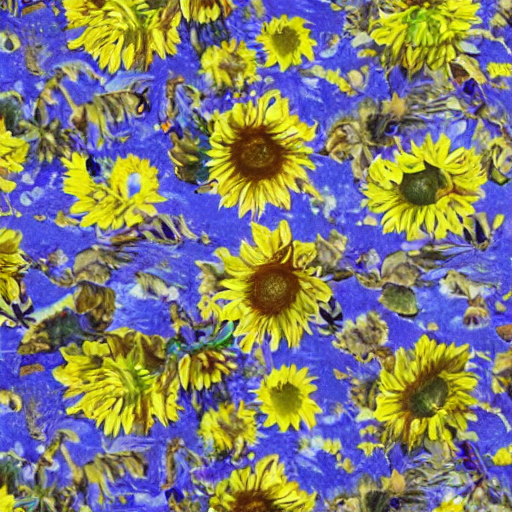

In [47]:
pipe.text_encoder.eval()
pipe.text_encoder = pipe.text_encoder.half()   

pipe.unet.eval()
pipe.vae.eval()

with torch.no_grad():
    image = pipe(
        "a sunflower field in van gogh style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

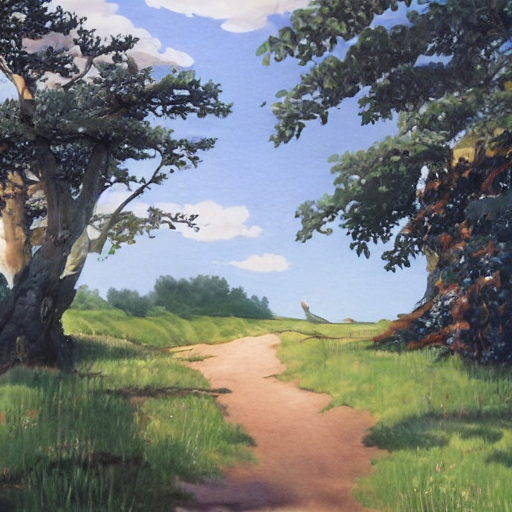

In [61]:
with torch.no_grad():
    image = pipe(
        "a peaceful countryside road with trees and clouds, studio ghibli style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

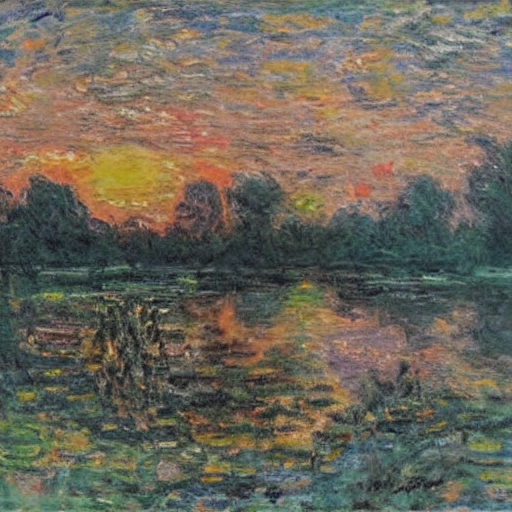

In [49]:
with torch.no_grad():
    image = pipe(
        "a pond with water lilies at sunrise, monet impressionist style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

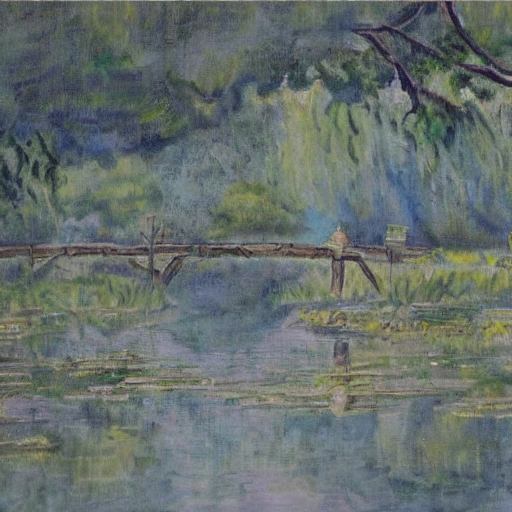

In [50]:
with torch.no_grad():
    image = pipe(
        "a dreamy landscape, ghibli and monet mixed style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

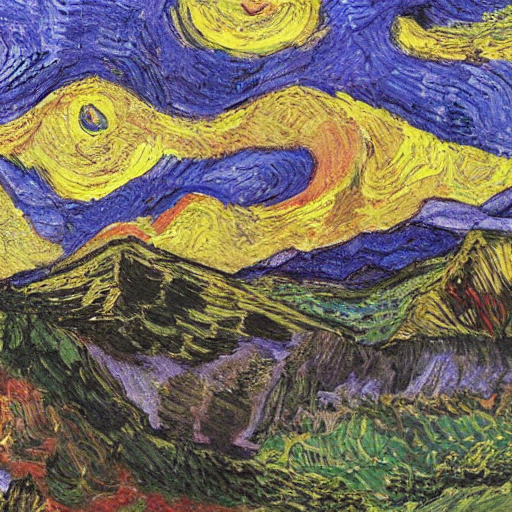

In [62]:
with torch.no_grad():
    image = pipe(
        "a mountain landscape at sunset, van gogh style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

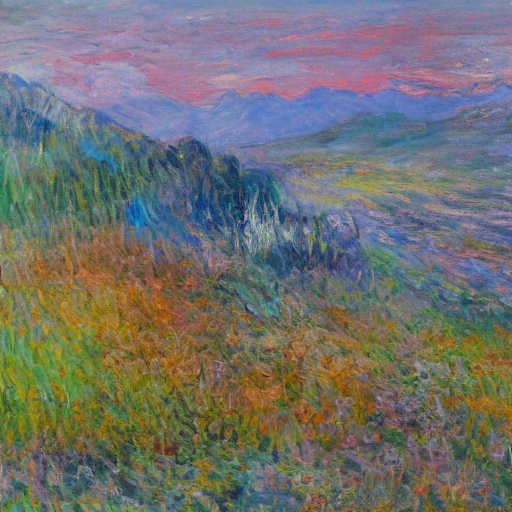

In [63]:
with torch.no_grad():
    image = pipe(
        "a mountain landscape at sunset, monet style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

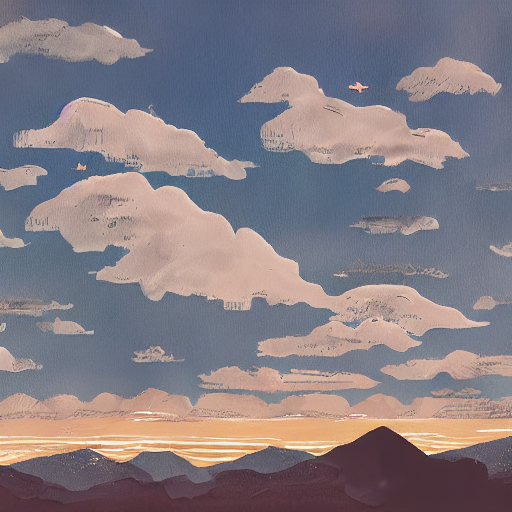

In [65]:
with torch.no_grad():
    image = pipe(
        "a mountain landscape at sunset, studio ghibli style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image

  0%|          | 0/30 [00:00<?, ?it/s]

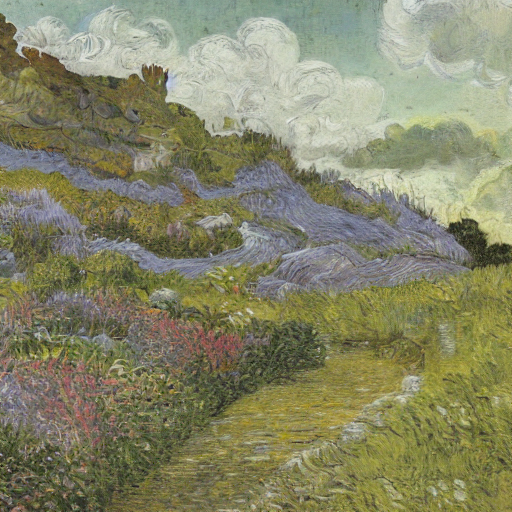

In [59]:
with torch.no_grad():
    image = pipe("a fantasy landscape with hills, flowers and sky, equal mix of van gogh texture, monet lighting and studio ghibli animation style",
        num_inference_steps=30,
        guidance_scale=2.0,
    ).images[0]

image